# Goal 1: Planck-Like likelihood

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%env OMP_NUM_THREADS=20

env: OMP_NUM_THREADS=20


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
fiducial_params = {
    'ombh2': 0.022, 'omch2': 0.12, 'H0': 68, 'tau': 0.07,
    'As': 2.2e-9, 'ns': 0.96,
    'mnu': 0.06, 'nnu': 3.046, 'num_massive_neutrinos': 1}

l_max = 2000

modules_path = '/home/zequnl/src/cobaya_modules'

info_fiducial = {
    'params': fiducial_params,
    'likelihood': {'one': None},
    'theory': {
        'camb': None
        
    }
}

from cobaya.model import get_model
model_fiducial = get_model(info_fiducial)

# Declare our desired theory product
# (there is no cosmological likelihood doing it for us)
model_fiducial.likelihood.theory.needs(Cl={'tt': l_max})

# Compute and extract the CMB power spectrum
# (In muK^-2, without l(l+1)/(2pi) factor)
# notice the empty dictionary below: all parameters are fixed
model_fiducial.logposterior({})
Cls = model_fiducial.likelihood.theory.get_Cl(ell_factor=False)

# Our fiducial power spectrum
Cl_est = Cls['tt'][:l_max+1]

[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *global* CAMB.


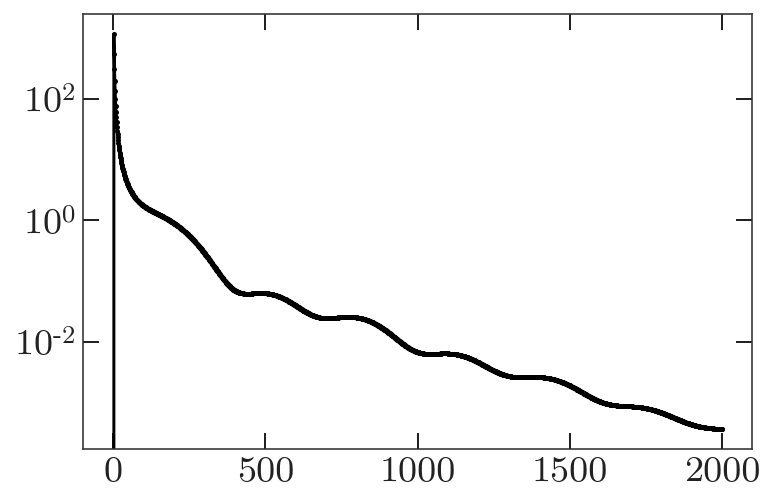

In [4]:
plt.plot(Cl_est)
plt.yscale('log')

In [5]:
def my_like(
        # Parameters that we may sample over (or not)
        beam_FWHM=0.25,  # deg
        # Declaration of our theory requirements
        _theory={'Cl': {'tt': l_max}},
        # Declaration of available derived parameters
        _derived={'Map_Cl_at_500': None}):
    
    # Noise spectrum, beam-corrected
    healpix_Nside=512
    noise_std_pixel= 20
    pixel_area_rad = np.pi/(3*healpix_Nside**2)
    weight_per_solid_angle = (noise_std_pixel**2 * pixel_area_rad)**-1
    beam_sigma_rad = beam_FWHM / np.sqrt(8*np.log(2)) * np.pi/180.
    ells = np.arange(l_max+1)
    Nl = np.exp((ells*beam_sigma_rad)**2)/weight_per_solid_angle
    # Cl of the map: data + noise
    Cl_map = Cl_est + Nl
    # Cl from theory: treat '_theory' as a 'theory code instance'
    Cl_theo = _theory.get_Cl(ell_factor=False)['tt'][:l_max+1]  # muK-2
    Cl_map_theo = Cl_theo + Nl
    # Set our derived parameter, assuming '_derived' is a dictionary
    _derived['Map_Cl_at_500'] = Cl_map[500]
    
    
    # Auxiliary plot
#     ell_factor = ells*(ells+1)/(2*np.pi)
#     plt.figure()
#     plt.plot(ells[2:], (Cl_theo*ell_factor)[2:], label=r'Theory $C_\ell$')
#     plt.plot(ells[2:], (Cl_est*ell_factor)[2:], label=r'Estimated $C_\ell$')
#     plt.plot(ells[2:], (Cl_map*ell_factor)[2:], label=r'Map $C_\ell$')
#     plt.plot(ells[2:], (Nl*ell_factor)[2:], label='Noise')
#     plt.legend()
#     plt.ylim([0, 6000])

    # ----------------
    # Compute the log-likelihood
    V = Cl_map[2:]/Cl_map_theo[2:]
    return np.sum((2*ells[2:]+1)*(-V/2 +1/2.*np.log(V)))

In [6]:
my_like(_theory=model_fiducial.likelihood.theory)

-2001998.5

In [7]:
info = {
    'params': {
        # Fixed
        'ombh2': 0.022, 'omch2': 0.12, 'H0': 68, 'tau': 0.07,
        'mnu': 0.06, 'nnu': 3.046, 'num_massive_neutrinos': 1,
        # Sampled
        
        'logA': {
            'prior': {'min': 1.61, 'max': 3.91}, 
            'ref' : {'dist' : 'norm', 'loc' : 3.05, 'scale' : 0.001},
            'proposal' : 0.001,
            'latex': '\log(10^{10} A_\mathrm{s})', 
            'drop': True
        },
        'ns': {
            'prior': {'min': 0.9, 'max': 1.1}, 
            'ref' : {'dist' : 'norm', 'loc' : 0.965, 'scale' : 0.004},
            'proposal' : 0.002,
            'latex': 'n_s'
        },
        
        # Derived
        
        'As': {'value':'lambda logA: 1e-10*np.exp(logA)', 'latex': 'A_s'},
    },
    'likelihood': {'my_cl_like': my_like},
    'theory': {'camb': {'stop_at_error': True}},
    'sampler': {
        'mcmc': {
            'covmat' : 'my_imaginary_cmb.covmat'
        }
    },  # or polychord...
    'debug' : True,
    'resume' : True,
#     'force' : True,
    
#     'modules': modules_path,
    'output': 'chains/my_imaginary_cmb'}

In [8]:
from cobaya.model import get_model
model = get_model(info)

[model] *WARNING* Ignored blocks/options: ['sampler', 'resume', 'output']
[my_cl_like] Initialised external likelihood.
[camb] Importing *global* CAMB.
[likelihood] The theory code will compute the following products, requested by the likelihoods: ['Cl']


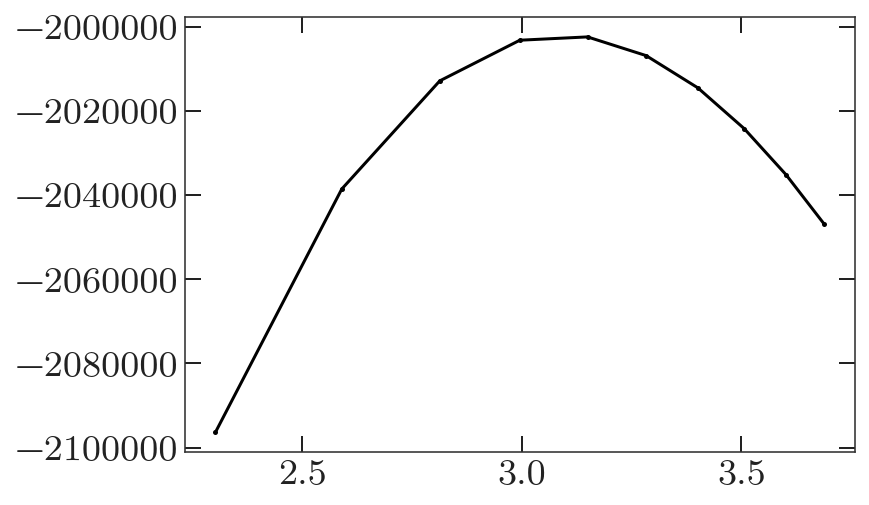

In [9]:
As = np.log(1e10 * np.linspace(1e-9, 4e-9, 10))
likes = [model.loglike({'logA': A, 'ns': 0.96})[0] for A in As]

plt.figure()
plt.plot(As, likes)
plt.show()

In [10]:
from cobaya.run import run
updated_info, products = run(info)

[output] Output to be read-from/written-into folder 'chains', with prefix 'my_imaginary_cmb'
[output] Found existing products with the requested ouput prefix: 'chains/my_imaginary_cmb'
[output] Let's try to resume/load.
[my_cl_like] Initialised external likelihood.
[camb] Importing *global* CAMB.
[likelihood] The theory code will compute the following products, requested by the likelihoods: ['Cl']
[mcmc] Resuming from previous sample!
[1] Loaded sample from 'chains/my_imaginary_cmb.1.txt'
[mcmc] Covariance matrix from checkpoint.
[mcmc] Initial point:
[mcmc] 
 weight  minuslogpost     logA       ns            As  minuslogprior  minuslogprior__0       chi2  chi2__my_cl_like
    1.0     2001998.2  3.09286  0.96133  2.204002e-09      -0.776529         -0.776529  4003997.9         4003997.9
[mcmc] Sampling! (NB: nothing will be printed until 2 burn-in samples have been obtained)
[mcmc] Sampling complete after 1760 accepted steps.


/home/zequnl/.conda/envs/ps/lib/python3.7/site-packages/cobaya/samplers/mcmc/mcmc.py:320: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  initial_point = (self.collection[self.collection.sampled_params]
/home/zequnl/.conda/envs/ps/lib/python3.7/site-packages/cobaya/samplers/mcmc/mcmc.py:322: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  logpost = -(self.collection[_minuslogpost]
/home/zequnl/.conda/envs/ps/lib/python3.7/site-packages/cobaya/samplers/mcmc/mcmc.py:324: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.py

In [13]:
from getdist import loadMCSamples

In [14]:
from getdist import plots

# gd_sample = MCSamplesFromCobaya(updated_info, products["sample"])
gd_sample = loadMCSamples("chains/my_imaginary_cmb")

[root] *WARNING* outlier fraction 0.019318181818181818 


Mean:
[3.09111612 0.96026266]
Covariance matrix:
[[4.02105039e-06 2.33038695e-06]
 [2.33038695e-06 1.45031259e-05]]


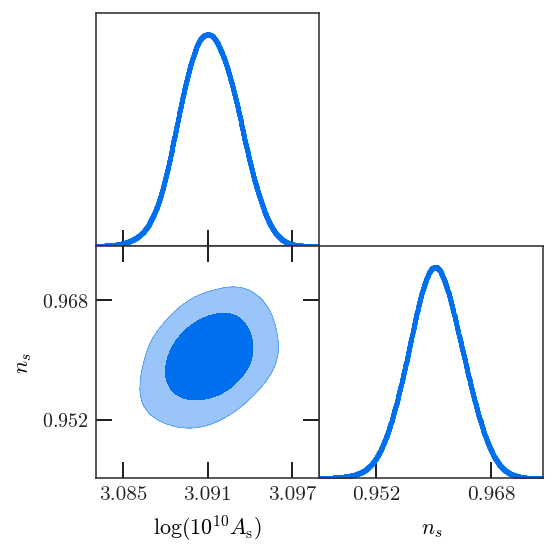

In [15]:
# Export the results to GetDist
# Analyze and plot
mean = gd_sample.getMeans()[:2]
covmat = gd_sample.getCovMat().matrix[:2, :2]
print("Mean:")
print(mean)
print("Covariance matrix:")
print(covmat)

%matplotlib inline
import getdist.plots as gdplt
gdplot = gdplt.getSubplotPlotter()
gdplot.triangle_plot(gd_sample, ["logA", "ns"], filled=True)

In [20]:
from cobaya.yaml import yaml_dump_file

In [23]:
yaml_dump_file("test.input.yaml", info)

In [29]:
! wc -l chains/raw_polychord_output/class_poly.txt

193 chains/raw_polychord_output/class_poly.txt


In [32]:
! cat chains/raw_polychord_output/class_poly.stats

Evidence estimates:
  - The evidence Z is a log-normally distributed, with location and scale parameters mu and sigma.
  - We denote this as log(Z) = mu +/- sigma.

Global evidence:
----------------

log(Z)       =  -0.200201090652892E+007 +/-   0.424373207526537E+000


Local evidences:
----------------

log(Z_ 1)  =  -0.200201119661196E+007 +/-   0.435475808170422E+000 (Still Active)
log(Z_ 2)  =  -0.200202343889738E+007 +/-   0.623766624635500E+000
log(Z_ 3)  =  -0.200201239394033E+007 +/-   0.606624017943793E+000


Run-time information:
---------------------

 ncluster:          1 /       3
 nposterior:      400
 nequals:           7
 ndead:           400
 nlive:            50
 nlike:          3236
 <nlike>:       10.90   (    5.45 per slice )


Dim No.       Mean        Sigma
  1  0.309030008653993E+001 +/-   0.000000000000000E+000
  2  0.960544523478670E+000 +/-   0.000000000000000E+000
-------------------------------
  3  0.219838090922362E-008 +/-   0.000000000000000E+000
  4  0